In [4]:
#initialize code 
#recommened to use the hypertools_cuda_ml image

import os
import sys

os.environ["XFORMERS_DISABLED"] = "1" # Switch to enable xFormers

    
import urllib
import io
import numpy as np
from PIL import Image 
from typing import Tuple
from sklearn.decomposition import PCA
from scipy.ndimage import binary_closing, binary_opening
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np


REPO_NAME = "facebookresearch/dino:main"
MODEL_NAME = "dino_vitb16"

def load_array_from_url(url: str) -> np.ndarray:
    with urllib.request.urlopen(url) as f:
        array_data = f.read()
        g = io.BytesIO(array_data)
        return np.load(g)


def load_image_from_url(url: str) -> Image:
    # with urllib.request.urlopen(url) as f:
    #     return Image.open(f).convert("RGB")
    return Image.open(url).convert("RGB")


def make_transform(smaller_edge_size: int) -> transforms.Compose:
    IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
    interpolation_mode = transforms.InterpolationMode.BICUBIC

    return transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=interpolation_mode, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ])


def prepare_image(image: Image,
                  smaller_edge_size: float,
                  patch_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    transform = make_transform(int(smaller_edge_size))
    print(image.size)
    image_tensor = transform(image)

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % patch_size, height - height % patch_size
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // patch_size, cropped_width // patch_size) # h x w (TODO: check)
    return image_tensor, grid_size


def make_foreground_mask(tokens,
                         grid_size: Tuple[int, int],
                         background_threshold: float = 0.0,
                         apply_opening: bool = True,
                         apply_closing: bool = True):
    projection = tokens @ standard_array
    mask = projection > background_threshold
    mask = mask.reshape(*grid_size)
    if apply_opening:
        mask = binary_opening(mask)
    if apply_closing:
        mask = binary_closing(mask)
    return mask.flatten()


def render_patch_pca(image: Image,
                     smaller_edge_size: float = 448,
                     patch_size: int = 16,
                     background_threshold: float = 0.05,
                     apply_opening: bool = False,
                     apply_closing: bool = False) -> Image:
    image_tensor, grid_size = prepare_image(image, smaller_edge_size, patch_size)

    with torch.inference_mode():
        image_batch = image_tensor.unsqueeze(0)
        tokens = model.get_intermediate_layers(image_batch)[0].squeeze()

    mask = make_foreground_mask(tokens,
                                grid_size,
                                background_threshold,
                                apply_opening,
                                apply_closing)

    pca = PCA(n_components=3)
    pca.fit(tokens[mask])
    projected_tokens = pca.transform(tokens)

    t = torch.tensor(projected_tokens)
    t_min = t.min(dim=0, keepdim=True).values
    t_max = t.max(dim=0, keepdim=True).values
    normalized_t = (t - t_min) / (t_max - t_min)

    array = (normalized_t * 255).byte().numpy()
    array[~mask] = 0
    array = array.reshape(*grid_size, 3)

    return Image.fromarray(array).resize((image.width, image.height), 0)


# sparse matching initialization 

class Dinov2Matcher:

  def __init__(self, repo_name='facebookresearch/dino:main', model_name="dino_vitb16", smaller_edge_size=448, half_precision=False, device="cuda"):
    self.repo_name = repo_name
    self.model_name = model_name
    self.smaller_edge_size = smaller_edge_size
    self.half_precision = half_precision
    self.device = device


    if self.half_precision:
      self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).half().to(self.device)
    else:
      self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).to(self.device)

    self.model.eval()
    self.model.patch_size = 16

    self.transform = transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet defaults
      ])

  # https://github.com/facebookresearch/dinov2/blob/255861375864acdd830f99fdae3d9db65623dafe/notebooks/features.ipynb
  def prepare_image(self, rgb_image_numpy):
    # image = Image.fromarray(rgb_image_numpy)
    
    if isinstance(rgb_image_numpy, np.ndarray):
        image = Image.fromarray(rgb_image_numpy)
    elif isinstance(rgb_image_numpy, Image.Image):
        image = rgb_image_numpy
    else:
        raise TypeError('rgb_image_numpy must be a NumPy array or a PIL Image')
    
    image_tensor = self.transform(image)
    resize_scale = image.width / image_tensor.shape[2]

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % self.model.patch_size, height - height % self.model.patch_size # crop a bit from right and bottom parts
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // self.model.patch_size, cropped_width // self.model.patch_size)
    return image_tensor, grid_size, resize_scale

  def prepare_mask(self, mask_image_numpy, grid_size, resize_scale):
    cropped_mask_image_numpy = mask_image_numpy[:int(grid_size[0]*self.model.patch_size*resize_scale), :int(grid_size[1]*self.model.patch_size*resize_scale)]
    image = Image.fromarray(cropped_mask_image_numpy)
    resized_mask = image.resize((grid_size[1], grid_size[0]), resample=Image.Resampling.NEAREST)
    resized_mask = np.asarray(resized_mask).flatten()
    return resized_mask

  def extract_features(self, image_tensor):
    with torch.inference_mode():
      if self.half_precision:
        image_batch = image_tensor.unsqueeze(0).half().to(self.device)
      else:
        image_batch = image_tensor.unsqueeze(0).to(self.device)

      tokens = self.model.get_intermediate_layers(image_batch)[0].squeeze()
    return tokens.cpu().numpy()

  def idx_to_source_position(self, idx, grid_size, resize_scale):
    row = (idx // grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
    col = (idx % grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
    return row, col

  def get_embedding_visualization(self, tokens, grid_size, resized_mask=None):
    pca = PCA(n_components=3)
    if resized_mask is not None:
      tokens = tokens[resized_mask]
    reduced_tokens = pca.fit_transform(tokens.astype(np.float32))
    if resized_mask is not None:
      tmp_tokens = np.zeros((*resized_mask.shape, 3), dtype=reduced_tokens.dtype)
      tmp_tokens[resized_mask] = reduced_tokens
      reduced_tokens = tmp_tokens
    reduced_tokens = reduced_tokens.reshape((*grid_size, -1))
    normalized_tokens = (reduced_tokens-np.min(reduced_tokens))/(np.max(reduced_tokens)-np.min(reduced_tokens))
    return normalized_tokens

def hconcat_resize(img_list,
                  interpolation
                  = cv2.INTER_CUBIC):
  # take minimum hights
  h_min = min(img.shape[0]
              for img in img_list)

  # image resizing
  im_list_resize = [cv2.resize(img,
                      (int(img.shape[1] * h_min / img.shape[0]),
                      h_min), interpolation
                                = interpolation)
                    for img in img_list]

  # return final image
  return cv2.hconcat(im_list_resize)





In [5]:
# set image files and default values
STANDARD_ARRAY_URL = "https://dl.fbaipublicfiles.com/dinov2/arrays/standard.npy"
EXAMPLE_IMAGE_URL = "../images/asd1.jpg"
EXAMPLE_IMAGE_URL2 = "../images/asd2.jpg"

standard_array = load_array_from_url(STANDARD_ARRAY_URL)



example_image = load_image_from_url(EXAMPLE_IMAGE_URL)
example_image2 = load_image_from_url(EXAMPLE_IMAGE_URL2)

# display(example_image)

REPO_NAME = "facebookresearch/dino_v2:main"
MODEL_NAME = "dino_vitb16"


DEFAULT_SMALLER_EDGE_SIZE = 448
DEFAULT_BACKGROUND_THRESHOLD = 0.05
DEFAULT_APPLY_OPENING = False
DEFAULT_APPLY_CLOSING = False

FileNotFoundError: [Errno 2] No such file or directory: '../images/asd1.jpg'

In [ ]:
# Init Dinov2Matcher
dm = Dinov2Matcher(half_precision=False)


# Extract features
image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(example_image)
features1 = dm.extract_features(image_tensor1)
# Visualization
vis_image = dm.get_embedding_visualization(features1, grid_size1)


image_tensor2, grid_size2, resize_scale2 = dm.prepare_image(example_image2)
features2 = dm.extract_features(image_tensor2)
# Visualization
vis_image2 = dm.get_embedding_visualization(features2, grid_size2)




fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(example_image)
plt.title('Image 1')

plt.subplot(1, 4, 2)  # 1 row, 3 columns, 3rd subplot = vis_image
plt.imshow(vis_image)
plt.title('Vis Image')

plt.subplot(1, 4, 3)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(example_image2)
plt.title('Image 2')

plt.subplot(1, 4, 4)  # 1 row, 3 columns, 3rd subplot = vis_image
plt.imshow(vis_image2)
plt.title('Vis Image2')

# plt.subplot(1, 4, 2)  # 1 row, 3 columns, 2nd subplot = mask1
# plt.imshow(mask1)
# plt.title('Mask 1')

plt.show()

# More info
# print("features1.shape:", features1.shape)
# print("image1.shape:", image1.shape)
# print("mask1.shape:", mask1.shape)
# print("image_tensor1.shape:", image_tensor1.shape)
# print("grid_size1:", grid_size1)
# print("resize_scale1:", resize_scale1)

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


NameError: name 'example_image' is not defined

In [ ]:
#sparse matching example 

dm = Dinov2Matcher(half_precision=False)

image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(example_image)
features1 = dm.extract_features(image_tensor1)       

image_tensor2, grid_size2, resize_scale2 = dm.prepare_image(example_image2)
features2 = dm.extract_features(image_tensor2)

# Build knn using features from image1, and query all features from image2
knn = NearestNeighbors(n_neighbors=1)
knn.fit(features1)
distances, match2to1 = knn.kneighbors(features2)
match2to1 = np.array(match2to1)

# plt.plot(sorted(distances)) #distance plt

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(example_image)
ax2.imshow(example_image2)
                                                    

for idx2, (dist, idx1) in enumerate(zip(distances, match2to1)):
  row, col = dm.idx_to_source_position(idx1, grid_size1, resize_scale1)
  xyA = (col, row)
  # if not mask1[int(row), int(col)]: continue # skip if feature is not on the object

  row, col = dm.idx_to_source_position(idx2, grid_size2, resize_scale2)
  xyB = (col, row)
  # if not mask2[int(row), int(col)]: continue # skip if feature is not on the object

  if np.random.rand() > 0.05: continue # sparsely draw so that we can see the lines... can uncomment for dense matching 

  con = ConnectionPatch(xyA=xyB, xyB=xyA, coordsA="data", coordsB="data",
                        axesA=ax2, axesB=ax1, color=np.random.rand(3,))
  ax2.add_artist(con)

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


NameError: name 'example_image' is not defined

In [ ]:
#generate feature patches for image 1 

print(f"using {MODEL_NAME} model")
model = torch.hub.load(repo_or_dir=REPO_NAME, model=MODEL_NAME)
model.eval()
model.patch_size = 16
print(f"patch size: {model.patch_size}")

image1_result = render_patch_pca(image=example_image,
                 smaller_edge_size=DEFAULT_SMALLER_EDGE_SIZE,
                 patch_size=model.patch_size,
                 #background_threshold=DEFAULT_BACKGROUND_THRESHOLD,
                 apply_opening=DEFAULT_APPLY_OPENING,
                 apply_closing=DEFAULT_APPLY_CLOSING)
# display(image1_result)



# run it all again for image 2 



model.eval()
model.patch_size = 16
print(f"patch size: {model.patch_size}")


image2_result = render_patch_pca(image=example_image2,
                 smaller_edge_size=DEFAULT_SMALLER_EDGE_SIZE,
                 patch_size=model.patch_size,
                 #background_threshold=DEFAULT_BACKGROUND_THRESHOLD,
                 apply_opening=DEFAULT_APPLY_OPENING,
                 apply_closing=DEFAULT_APPLY_CLOSING)
# display(image2_result)

using dino_vitb16 model


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


patch size: 16


NameError: name 'example_image' is not defined

In [ ]:
#display results

#resize images to same size 
default_width = 448
default_height = 448
image1_result = image1_result.resize((default_width, default_height))
image2_result = image2_result.resize((default_width, default_height))

# display(image1_result)
# display(image2_result)


# Create a new image with width as the sum of both image widths and height as the maximum of image heights
new_image = Image.new('RGB', (default_width * 2, default_height))

# Paste the images into the new image
new_image.paste(image1_result, (0, 0))
new_image.paste(image2_result, (default_width, 0))

# Display the new image
display(new_image)

#show the original images
# display(example_image)
new_image2 = Image.new('RGB', (default_width * 2, default_height))
example_image = example_image.resize((default_width, default_height))
example_image2 = example_image2.resize((default_width, default_height))
new_image2.paste(example_image, (0, 0))
new_image2.paste(example_image2, (default_width, 0))
display(new_image2)



# Blend the images
alpha = 0.5  # Transparency factor

# The two images must be the same size
if new_image.size != new_image2.size:
    print("Images do not have the same size!")
else:
    blended = Image.blend(new_image, new_image2, alpha)

    # Display the blended image
    display(blended)


NameError: name 'image1_result' is not defined

In [ ]:
#import cuvis  #need to make sure python3.9 kernel is selected
import numpy as np
import cv2
from IPython.display import clear_output
import rasterio as rio
import cuvis
from processor import Processor

def   reprocessMeasurement(userSettingsDir,measurementLoc,darkLoc,whiteLoc,distanceLoc,factoryDir):    
    
    # print("loading user settings...")
    settings = cuvis.General(userSettingsDir)
    # settings.setLogLevel("info")

    # print("loading measurement file...")
    mesu = cuvis.Measurement(measurementLoc)

    # print("loading dark...")
    dark = cuvis.Measurement(darkLoc)
    # print("loading white...")
    white = cuvis.Measurement(whiteLoc)
    # print("loading dark...")
    distance = cuvis.Measurement(distanceLoc)

    # print("Data 1 {} t={}ms mode={}".format(mesu.Name,mesu.IntegrationTime,mesu.ProcessingMode,))

    # print("loading calibration and processing context (factory)...")
    calibration = cuvis.Calibration(factoryDir)
    processingContext = cuvis.ProcessingContext(calibration)

    # print("set references...")
    processingContext.set_reference(dark, cuvis.ReferenceType.Dark)
    processingContext.set_reference(white, cuvis.ReferenceType.White)
    processingContext.set_reference(distance, cuvis.ReferenceType.Distance)

    modes = [
             "Reflectance"
             ]

    # procArgs = cuvis.CubertProcessingArgs()
    procArgs = cuvis.ProcessingArgs()
    # saveArgs = cuvis.SaveArgs(allow_overwrite=True)

    for mode in modes:

        procArgs.ProcessingMode = mode
        isCapable = processingContext.is_capable(mesu, procArgs)

        if isCapable:
            # print("processing to mode {}...".format(mode))
            processingContext.set_processing_args(procArgs)
            mesu = processingContext.apply(mesu)
            mesu.set_name(mode)
            # cube = mesu.Data.pop("cube", None)
            cube = mesu.data.get("cube", None)
            
            if cube is None:
                raise Exception("Cube not found")

        else:
            print("Cannot process to {} mode!".format(mode))
            
    #print("finished.")
    cube_result = cube.array
    cube_result = np.transpose(cube_result, (2, 0, 1))
    # print(cube_result.shape)
    return cube_result

def extract_rgb(cube, red_layer=78 , green_layer=40, blue_layer=25,  visualize=False):

    
    red_img = cube[ red_layer,:,:]
    green_img = cube[ green_layer,:,:]
    blue_img = cube[ blue_layer,:,:]

        
    data=np.stack([red_img,green_img,blue_img], axis=-1)
    # print(data.shape)
    #print(type(image))

    #convert to 8bit
    x_norm = (data-np.min(data))/(np.max(data)-np.min(data))
    image=(x_norm*255).astype('uint8')
    if visualize:
        #pass
        plt.imshow(image)
        plt.show()
    return image  

def format_images_for_pca(data):
    # Initialize an empty list to hold the reshaped images
    reshaped_data = []
    
    for img in data:
        # Reshape the image to have shape (1, number of elements)
        reshaped_img = img.flatten()
        
        # Convert the image data to float32
        reshaped_img = reshaped_img.astype(np.float32)
        
        # Append the reshaped image to the list
        reshaped_data.append(reshaped_img)
    
    # Convert the list to a numpy array
    dst = np.array(reshaped_data)
    
    return dst    

def customPCA(X, num_components ):
    # Step 1: Center the data
    X_meaned = X - np.mean(X, axis=0)
    
    # Step 2: Compute the covariance matrix
    cov_mat = np.cov(X_meaned, rowvar=False)
    
    # Step 3: Compute eigenvalues and eigenvectors
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)
    
    # Step 4: Sort eigenvalues in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:, sorted_index]
    
    # Step 5: Select the top 'num_components' eigenvectors
    eigenvector_subset = sorted_eigenvectors[:, 0:num_components]
    
    # Step 6: Project data onto reduced subspace
    X_reduced = np.dot(eigenvector_subset.transpose(), X_meaned.transpose()).transpose()
    
    return X_reduced
    
    
# userSettingsDir = "../settings/ultris20/" 
# measurementLoc = "../../HyperImages/cornfields/session_002/session_002_490.cu3"
# darkLoc = "../../HyperImages/cornfields/Calibration/dark__session_002_003_snapshot16423119279414228.cu3"
# whiteLoc = "../../HyperImages/cornfields/Calibration/white__session_002_752_snapshot16423136896447489.cu3"
# distanceLoc = "../../HyperImages/cornfields/Calibration/distanceCalib__session_000_790_snapshot16423004058237746.cu3"
# factoryDir = "../settings/ultris20/" # init.daq file
# outDir ="../../HyperImages/export/"

# cube = reprocessMeasurement(userSettingsDir,measurementLoc,darkLoc,whiteLoc,distanceLoc,factoryDir)
# 


"""Using processor functionality to extract vals from TIFF
"""

p = Processor()
hsi = p.prepare_data(r'/workspaces/HyperGAN/datasets/export_2/testB/session_000_001k_022_snapshot_ref.tiff')


clear_output()
# print('before image',image0.shape)
# plt.imshow(image0)

print('before',hsi.shape)
cube = np.transpose(hsi, (2, 0, 1))
image0=p.genFalseRGB(convertPIL=True)

data = format_images_for_pca(cube)
data = data.transpose(1,0)
print('after', data.shape)
reduced_image_layers = 3
# Assuming 'data' is your input and 'reduced_image_layers' is the number of components
data = np.float32(data)
# mean, eigenvectors  = cv2.PCACompute(data, mean=np.empty((0)), maxComponents=reduced_image_layers)

eigen_img = customPCA(data, reduced_image_layers)
print('eigen_img', eigen_img.shape)
eigen_img = eigen_img.reshape( cube.shape[1], cube.shape[2],reduced_image_layers)

# print('mean', mean.shape)
# print('eigenvectors', eigenvectors.shape)
# #reshape eigen vectors
# eigen_img = eigenvectors.reshape(reduced_image_layers, cube.shape[1], cube.shape[2])
# eigen_img = np.transpose(eigen_img, (1, 2, 0))
# print('eigen_img', eigen_img.shape)
# plt.imshow(eigen_img)
# display(eigen_img)
# # principal_components = pca[0]  # eigenvectors

# Assuming 'input_image' is your input image
# input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

# List to store the reduced images
# reduced_images = []

# for i in range(reduced_image_layers):
#     point = cv2.PCAProject(data, mean, eigenvectors)
#     print('point shape', point.shape)
    
#     eigen_img = point.reshape(reduced_image_layers, cube.shape[1], cube.shape[2])
    # reconstruction = cv2.PCABackProject(data, mean, eigenvectors)
    # print('reconstruction shape', reconstruction.shape)
#     # Reshape the reconstruction into the shape of the input image
#     layer = reconstruction.reshape(data.shape)
    
#     # Convert the layer to grayscale
#     layer = cv2.cvtColor(layer, cv2.COLOR_BGR2GRAY)
    
#     # Append the layer to the list of reduced images
#     reduced_images.append(layer)
    
# plt.imshow(reduced_images)
# print(reduced_images.shape)
# eigen_img = np.transpose(eigen_img, (1, 2, 0))
# plt.imshow(eigen_img)
# display(eigen_img)

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(eigen_img)
plt.title('Fused Image')

plt.subplot(1, 5, 4)  # 1 row, 3 columns, 3rd subplot = vis_image
red_channel_img = eigen_img.copy()
red_channel_img[:, :, 1] = 0
red_channel_img[:, :, 2] = 0
plt.imshow(red_channel_img)
plt.title('Layer 2 ')

plt.subplot(1, 5, 3)  # 1 row, 3 columns, 3rd subplot = vis_image
blue_channel_img = eigen_img.copy()
blue_channel_img[:, :, 0] = 0
blue_channel_img[:, :, 2] = 0
plt.imshow(blue_channel_img)
plt.title('Layer 1')

plt.subplot(1, 5, 2)  # 1 row, 3 columns, 3rd subplot = vis_image
green_channel_img = eigen_img.copy()
green_channel_img[:, :, 1] = 0
green_channel_img[:, :, 0] = 0
plt.imshow(green_channel_img)
plt.title('Layer 0')

plt.subplot(1, 5, 5)  # 1 row, 3 columns, 3rd subplot = vis_image

plt.imshow(image0)
plt.title('RGB Image')


before (256, 256, 51)
after (65536, 51)
eigen_img (65536, 3)


NameError: name 'plt' is not defined

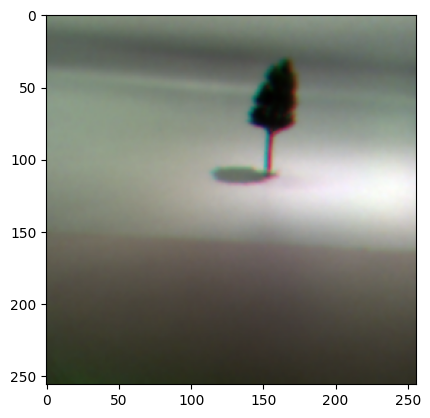

array([[[124, 140, 119],
        [124, 141, 119],
        [123, 141, 118],
        ...,
        [142, 153, 136],
        [142, 153, 135],
        [141, 153, 134]],

       [[122, 137, 117],
        [122, 139, 115],
        [121, 139, 115],
        ...,
        [139, 151, 136],
        [141, 152, 135],
        [140, 152, 133]],

       [[119, 135, 113],
        [120, 137, 113],
        [120, 138, 114],
        ...,
        [138, 148, 136],
        [139, 148, 134],
        [139, 150, 132]],

       ...,

       [[ 38,  46,  27],
        [ 38,  47,  28],
        [ 37,  49,  28],
        ...,
        [ 49,  48,  34],
        [ 49,  47,  37],
        [ 49,  47,  38]],

       [[ 39,  46,  27],
        [ 39,  46,  28],
        [ 38,  48,  28],
        ...,
        [ 48,  47,  36],
        [ 48,  46,  37],
        [ 48,  46,  38]],

       [[ 39,  46,  27],
        [ 39,  46,  28],
        [ 38,  47,  28],
        ...,
        [ 47,  46,  36],
        [ 47,  46,  37],
        [ 47,  46,  38]]

In [ ]:
from processor import Processor

p = Processor()
hsi = p.prepare_data('/workspaces/HyperGAN/datasets/export_2/trainA/session_000_001k_048_snapshot_ref.tiff')
p.genFalseRGB(visualize=True)

In [ ]:
# Init Dinov2Matcher
dm = Dinov2Matcher(half_precision=False)


# Extract features
# eigen_img= Image.fromarray((eigen_img * 255).astype(np.uint8).reshape(eigen_img.shape[1:]))


max_value = np.amax(eigen_img)
min_value = np.amin(eigen_img)

print('Max value:', max_value)
print('Min value:', min_value)

normalized_array = (eigen_img - min_value) / (max_value - min_value)

eigen_img2 = Image.fromarray((normalized_array*255 ).astype(np.uint8))
image_tensor3, grid_size3, resize_scale3 = dm.prepare_image(eigen_img2)
features3 = dm.extract_features(image_tensor3)
# # Visualization
vis_image = dm.get_embedding_visualization(features3, grid_size3)


fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(eigen_img2)
plt.title('Image 1')

plt.subplot(1, 4, 2)  # 1 row, 3 columns, 3rd subplot = vis_image
plt.imshow(eigen_img)
plt.title('Orig Image')

plt.subplot(1, 4, 3)  # 1 row, 3 columns, 3rd subplot = vis_image
plt.imshow(vis_image)
plt.title('Vis Image')

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Max value: 995.4874614929707
Min value: -709.2918749372014


ValueError: cannot reshape array of size 2355 into shape (28,28,newaxis)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'RGB Image')

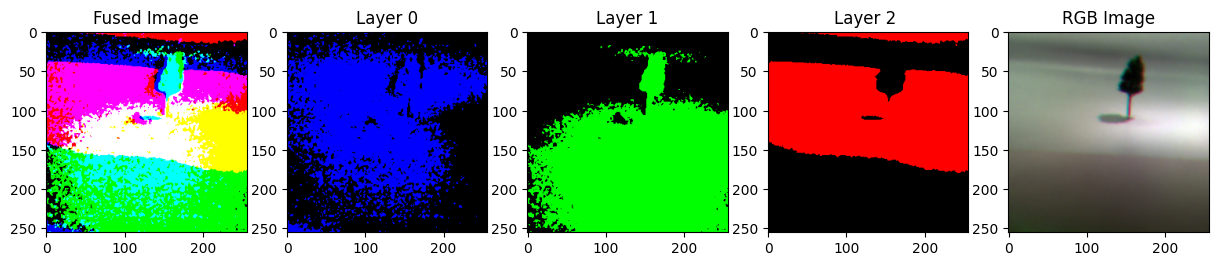

In [ ]:
measurementLoc = "../../HyperImages/cornfields/session_002/session_002_491.cu3"
cube2 = cube
#reprocessMeasurement(userSettingsDir,measurementLoc,darkLoc,whiteLoc,distanceLoc,factoryDir)
image2=image0
#extract_rgb(cube2)

clear_output()
data2 = format_images_for_pca(cube2)
data2 = data2.transpose(1,0)
data2 = np.float32(data2)
eigen_img3 = customPCA(data2, reduced_image_layers)
eigen_img3 = eigen_img3.reshape( cube2.shape[1], cube2.shape[2],reduced_image_layers)

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(eigen_img3)
plt.title('Fused Image')

plt.subplot(1, 5, 4)  # 1 row, 3 columns, 3rd subplot = vis_image
red_channel_img = eigen_img3.copy()
red_channel_img[:, :, 1] = 0
red_channel_img[:, :, 2] = 0
plt.imshow(red_channel_img)
plt.title('Layer 2 ')

plt.subplot(1, 5, 3)  # 1 row, 3 columns, 3rd subplot = vis_image
blue_channel_img = eigen_img3.copy()
blue_channel_img[:, :, 0] = 0
blue_channel_img[:, :, 2] = 0
plt.imshow(blue_channel_img)
plt.title('Layer 1')

plt.subplot(1, 5, 2)  # 1 row, 3 columns, 3rd subplot = vis_image
green_channel_img = eigen_img3.copy()
green_channel_img[:, :, 1] = 0
green_channel_img[:, :, 0] = 0
plt.imshow(green_channel_img)
plt.title('Layer 0')

plt.subplot(1, 5, 5)  # 1 row, 3 columns, 3rd subplot = vis_image

plt.imshow(image2)
plt.title('RGB Image')

Max value: 995.4874614929707
Min value: -709.2918749372014


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Vis Image')

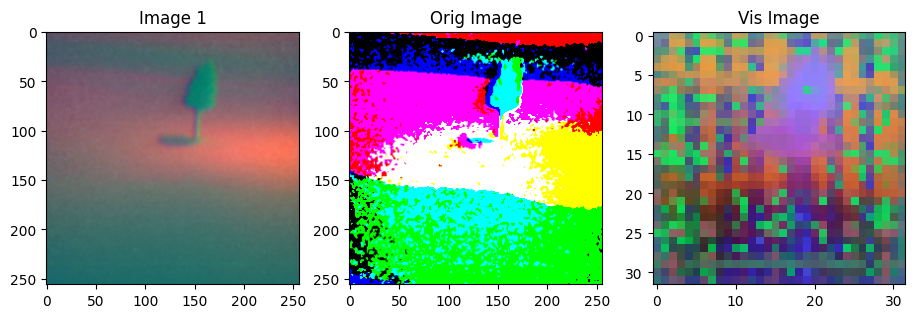

In [ ]:
max_value = np.amax(eigen_img3)
min_value = np.amin(eigen_img3)

print('Max value:', max_value)
print('Min value:', min_value)

normalized_array2 = (eigen_img3 - min_value) / (max_value - min_value)

eigen_img4 = Image.fromarray((normalized_array2*255 ).astype(np.uint8))
image_tensor4, grid_size4, resize_scale4 = dm.prepare_image(eigen_img4)
features4 = dm.extract_features(image_tensor4)
# # Visualization
vis_image = dm.get_embedding_visualization(features4, grid_size4)


fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(eigen_img4)
plt.title('Image 1')

plt.subplot(1, 4, 2)  # 1 row, 3 columns, 3rd subplot = vis_image
plt.imshow(eigen_img3)
plt.title('Orig Image')

plt.subplot(1, 4, 3)  # 1 row, 3 columns, 3rd subplot = vis_image
plt.imshow(vis_image)
plt.title('Vis Image')